In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from keras_tuner import RandomSearch
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [ ]:
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  Tesla T4
Using device: cuda


In [ ]:
new_df = pd.read_csv('sentiment_scored_.csv')

In [ ]:
new_df = new_df.sort_values(by='timestamp')

In [ ]:
new_df.drop(columns=['Unnamed: 0'],inplace=True)

In [ ]:
new_df.head()

,rating,text,timestamp,rob_neg,rob_neu,rob_pos
11566,4,Easy to use. Non invasive. Vibrates with resul...,2018-05-11 17:21:49.173,0.013828,0.014668,0.971504
15082,5,This is the easiest thermometer that gives the...,2018-05-12 18:36:23.059,0.014745,0.014590,0.970665
1903,5,Easy to use. Easy to read display. Light weigh...,2018-05-13 00:28:58.218,0.016857,0.024825,0.958318
15180,4,I like that you don't touch the skin; that it ...,2018-05-24 16:19:08.822,0.082151,0.121618,0.796231
15771,4,My only complaint is that it does not work wit...,2018-05-24 17:02:23.110,0.057362,0.056420,0.886218


### Performing Moving Average

In [ ]:
new_df['timestamp'] = pd.to_datetime(new_df['timestamp'], errors='coerce')

In [ ]:
new_df['moving_average_neg'] = new_df['rob_neg'].rolling(window=30, min_periods=1).mean()
new_df['moving_average_neu'] = new_df['rob_neu'].rolling(window=30, min_periods=1).mean()
new_df['moving_average_pos'] = new_df['rob_pos'].rolling(window=30, min_periods=1).mean()

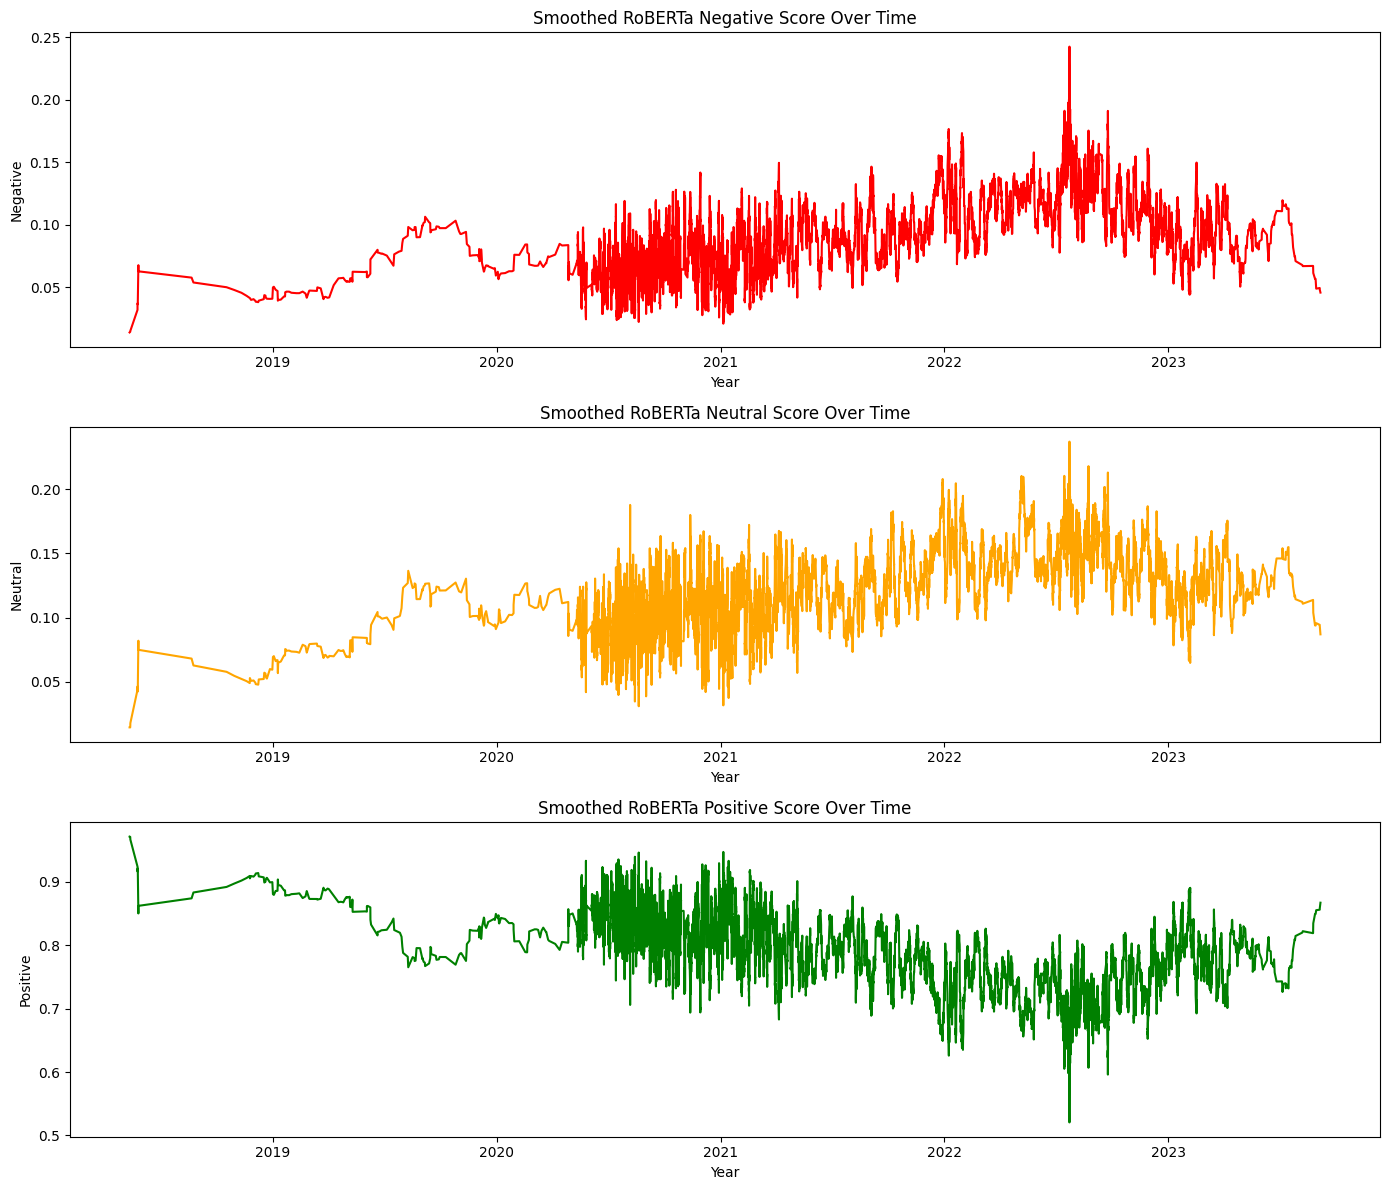

In [ ]:
fig, arr = plt.subplots(3, 1, figsize=(14, 12))

arr[0].plot(new_df['timestamp'], new_df['moving_average_neg'], color='red')
arr[0].set_title("Smoothed RoBERTa Negative Score Over Time")
arr[0].set_ylabel("Negative")
arr[0].set_xlabel("Year")

arr[1].plot(new_df['timestamp'], new_df['moving_average_neu'], color='orange')
arr[1].set_title("Smoothed RoBERTa Neutral Score Over Time")
arr[1].set_ylabel("Neutral")
arr[1].set_xlabel("Year")

arr[2].plot(new_df['timestamp'], new_df['moving_average_pos'], color='green')
arr[2].set_title("Smoothed RoBERTa Positive Score Over Time")
arr[2].set_ylabel("Positive")
arr[2].set_xlabel("Year")

plt.tight_layout()
plt.show()


In [ ]:
class Forecast_Sentiments:

    def __init__(self):
        self.WINDOW_SIZE = 30
        self.shape = None
        self.X = None
        self.y = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.cp = None
        self.model1 = None
        self.history = None
        self.best_model = None
        self.scaler = MinMaxScaler()
        self.earlystopping = EarlyStopping(
            monitor="val_loss",
            patience=1,
            verbose=1,
            mode="min",
            restore_best_weights=True
        )

    def df_to_X_y(self, df, window_Size=30):
        self.WINDOW_SIZE = window_Size
        self.shape = df.shape[0]

        df_scaled = self.scaler.fit_transform(df.values.reshape(-1, 1))
        X = []
        y = []
        for i in tqdm(range(len(df_scaled) - window_Size)):
            row = [[a] for a in df_scaled[i:i + window_Size]]
            X.append(row)
            label = df_scaled[i + window_Size]
            y.append(label)

        self.X = np.array(X)
        self.y = np.array(y)

    def split_data_points(self, test_size=0.2):
        size = int(np.round(self.shape * (1 - test_size)))
        self.X_train = self.X[:size]
        self.y_train = self.y[:size]
        self.X_test = self.X[size:]
        self.y_test = self.y[size:]

    def train_stacked_lstm_model(self, learning_rate=0.001):
        self.model1 = Sequential([
            InputLayer((self.WINDOW_SIZE, 1)),
            LSTM(64, return_sequences=True),
            Dropout(0.2),
            LSTM(64, return_sequences=True),
            Dropout(0.2),
            LSTM(64),
            Dropout(0.2),
            Dense(8, activation='relu'),
            Dense(1, activation='linear')
        ])

        self.model1.summary()

        self.cp = ModelCheckpoint(
            'model_.keras',
            save_best_only=True,
        )

        self.model1.compile(
            loss=MeanSquaredError(),
            optimizer=Adam(learning_rate=learning_rate),
            metrics=[RootMeanSquaredError()]
        )

    def fit_model(self, epochs=50):
        self.history = self.model1.fit(
            self.X_train,
            self.y_train,
            validation_split=0.2,
            shuffle=False,
            epochs=epochs,
            callbacks=[self.cp, self.earlystopping]
        )

        plt.figure(figsize=(10, 5))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Training vs Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    def forecast_model(self):
        if self.best_model is None:
            self.best_model = load_model('model_.keras')
        predictions = self.best_model.predict(self.X_test)
        inverse_pred = self.scaler.inverse_transform(predictions)
        inverse_actual = self.scaler.inverse_transform(self.y_test.reshape(-1, 1))
        return pd.DataFrame({'Test Prediction': inverse_pred.flatten(), 'Actual': inverse_actual.flatten()})

    def evaluation(self, model_df):
        mse = mean_squared_error(model_df['Actual'], model_df['Test Prediction'])
        rmse = np.sqrt(mse)
        r2 = r2_score(model_df['Actual'], model_df['Test Prediction'])
        mae = mean_absolute_error(model_df['Actual'], model_df['Test Prediction'])

        print(f'MSE  : {mse:.4f}')
        print(f'RMSE : {rmse:.4f}')
        print(f'R²   : {r2:.4f}')
        print(f'MAE  : {mae:.4f}')

    def forecast_visual(self, model_df, text=""):
        plt.figure(figsize=(12, 5))
        plt.plot(model_df['Test Prediction'], label='Predicted', alpha=0.8)
        plt.plot(model_df['Actual'], label='Actual', alpha=0.6)
        plt.title(f'{text} Sentiment Model Prediction vs Actual Values')
        plt.xlabel('Time Step')
        plt.ylabel('Sentiment Score')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


In [ ]:
neutral_sentiment = Forecast_Sentiments()

In [ ]:
negative_sentiment = Forecast_Sentiments()
neutral_sentiment = Forecast_Sentiments()
positive_sentiment = Forecast_Sentiments()


### Peforming Model For Negative Sentiment

In [ ]:
negative_sentiment.df_to_X_y(new_df['moving_average_neg'])

100%|██████████| 16827/16827 [00:01<00:00, 10347.11it/s]


In [ ]:
negative_sentiment.split_data_points()

In [ ]:
negative_sentiment.train_stacked_lstm_model(learning_rate=0.001)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,473 (326.07 KB)

 Trainable params: 83,473 (326.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0079 - root_mean_squared_error: 0.0851 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0615
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0415
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0011 - root_mean_squared_error: 0.0336 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 8.7438e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6.9295e-04 - root_mean_squared_error: 0.0263 - val_loss: 9.1702e-04 - val_root_mean_squared_error: 0.0303
Epoch 6/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5.6957e-04 - root_mean_squared_error: 0.0238 - val_loss: 9.1818e-04 - val_root_mean_squared_error: 0.0303
Epoch 6: early stopping
R

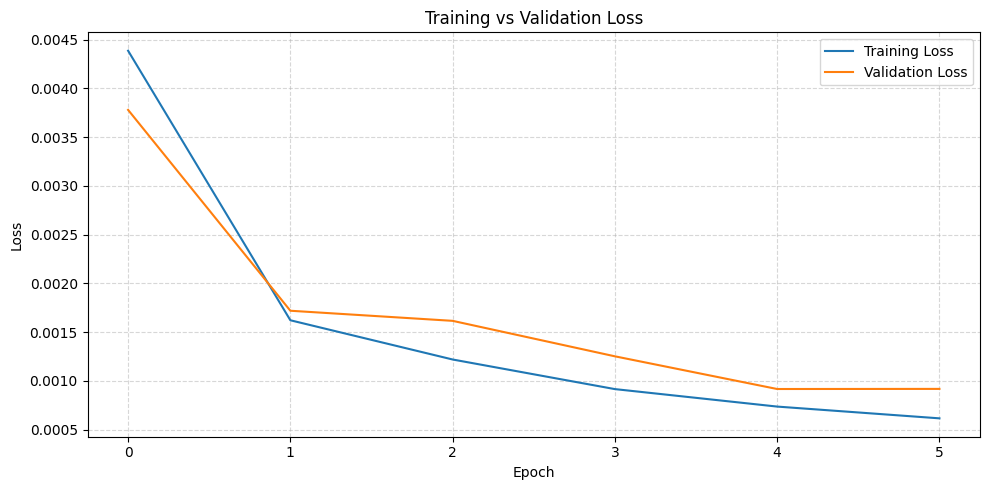

In [ ]:
negative_sentiment.fit_model()

In [ ]:
negative_sentiment_model = negative_sentiment.forecast_model()

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [ ]:
negative_sentiment.evaluation(negative_sentiment_model)

MSE  : 0.0001
RMSE : 0.0085
R²   : 0.9113
MAE  : 0.0069


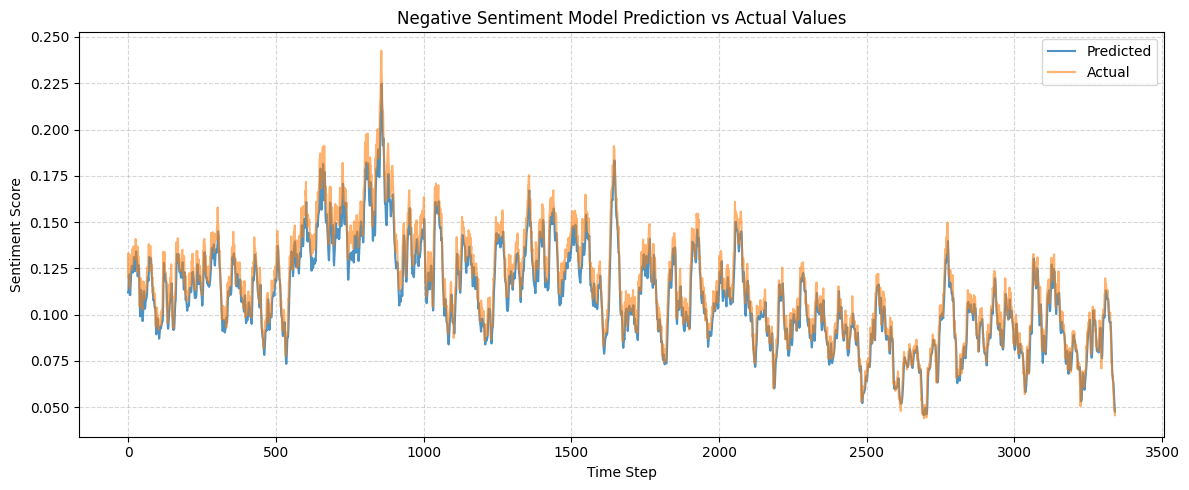

In [ ]:
negative_sentiment.forecast_visual(negative_sentiment_model,text = 'Negative')

### Peforming Model For Positive Sentiment

In [ ]:
positive_sentiment.df_to_X_y(new_df['moving_average_pos'])

100%|██████████| 16827/16827 [00:00<00:00, 18908.53it/s]


In [ ]:
positive_sentiment.split_data_points()

In [ ]:
positive_sentiment.train_stacked_lstm_model(learning_rate=0.0001)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,473 (326.07 KB)

 Trainable params: 83,473 (326.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1362 - root_mean_squared_error: 0.3421 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0788
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0739
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0731
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0728
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0688
Epoch 6/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0638
Epoch 7/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 12m

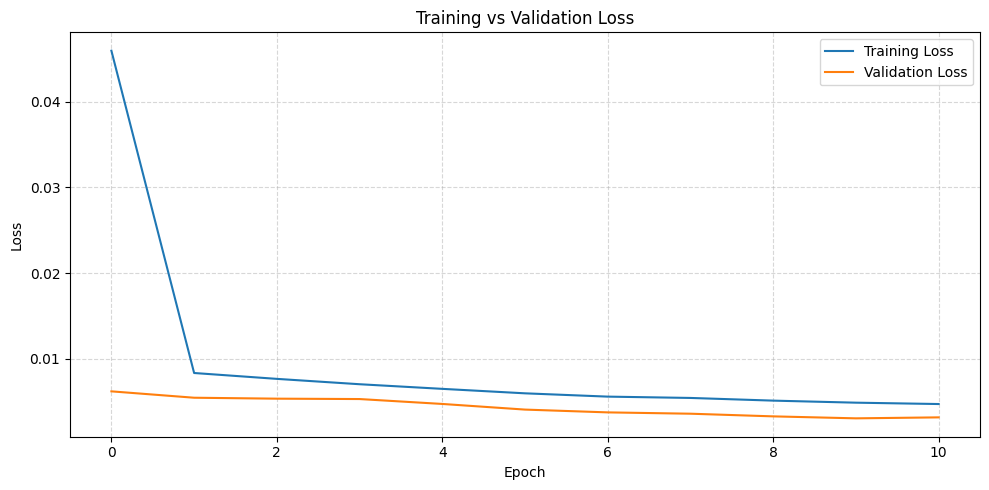

In [ ]:
positive_sentiment.fit_model()

In [ ]:
positive_sentiment_model = positive_sentiment.forecast_model()

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
positive_sentiment.evaluation(positive_sentiment_model)

MSE  : 0.0011
RMSE : 0.0326
R²   : 0.6014
MAE  : 0.0258


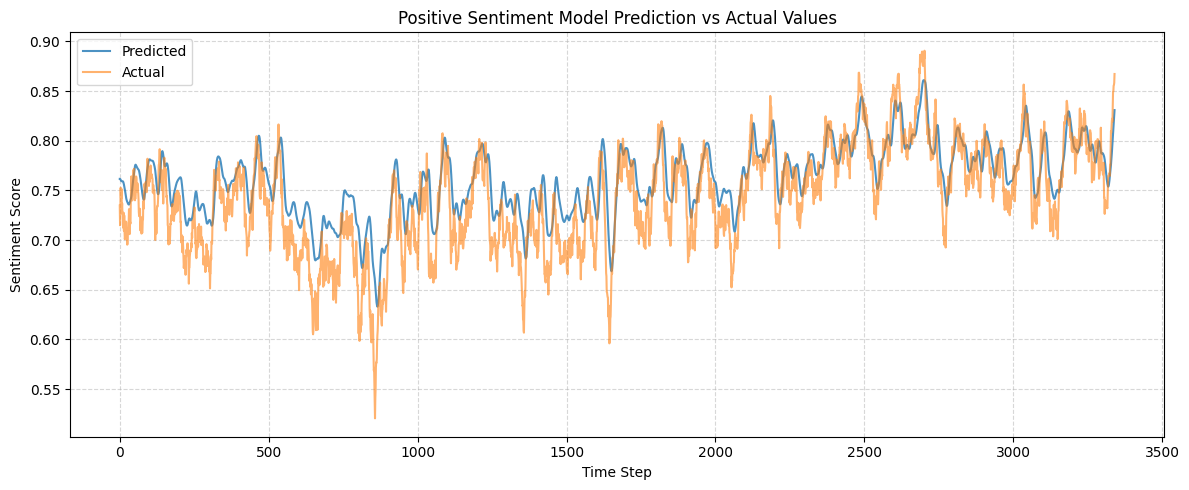

In [ ]:
positive_sentiment.forecast_visual(positive_sentiment_model,text='Positive')

### Performing Model For Neutral sentiment

In [ ]:
neutral_sentiment.df_to_X_y(new_df['moving_average_neu'])

100%|██████████| 16827/16827 [00:00<00:00, 21621.93it/s]


In [ ]:
neutral_sentiment.split_data_points()

In [ ]:
neutral_sentiment.train_stacked_lstm_model(learning_rate=0.001)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,473 (326.07 KB)

 Trainable params: 83,473 (326.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0113 - root_mean_squared_error: 0.1024 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0497
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0031 - root_mean_squared_error: 0.0552 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0022 - root_mean_squared_error: 0.0464 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0341
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 9.5395e-04 - val_root_mean_squared_error: 0.0309
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 4.


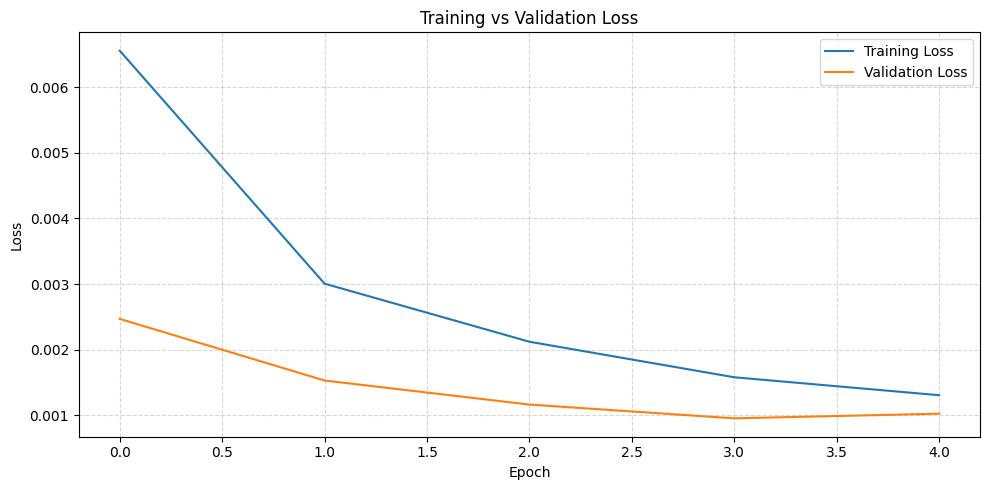

In [ ]:
neutral_sentiment.fit_model()

In [ ]:
neutral_sentiment_model = neutral_sentiment.forecast_model()

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
neutral_sentiment.evaluation(neutral_sentiment_model)

MSE  : 0.0001
RMSE : 0.0072
R²   : 0.9167
MAE  : 0.0058


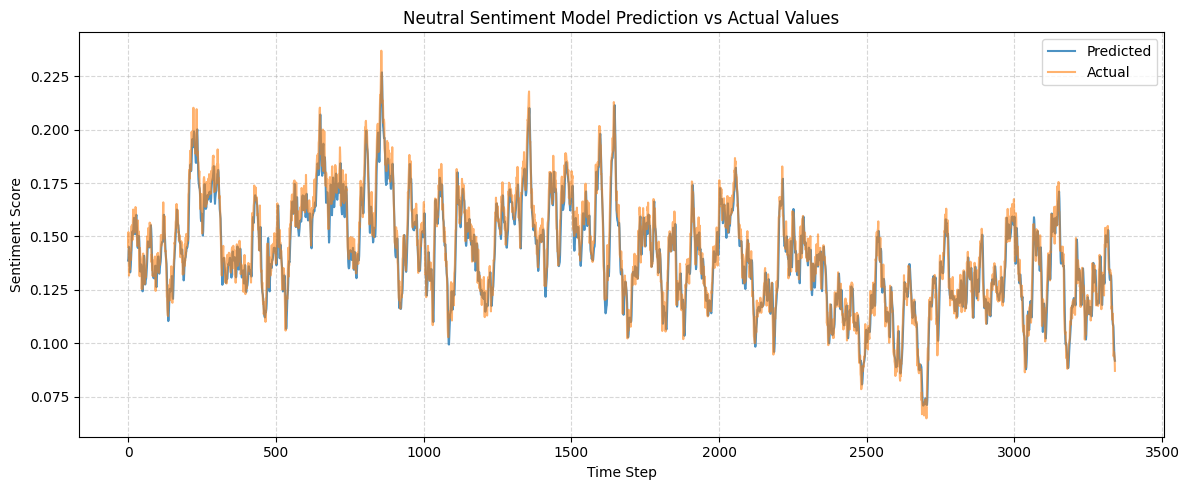

In [ ]:
neutral_sentiment.forecast_visual(neutral_sentiment_model,text='Neutral')

### Forecasting positive Score in different way

In [ ]:
positive_score = 1 - negative_sentiment_model['Test Prediction'] - neutral_sentiment_model['Test Prediction']

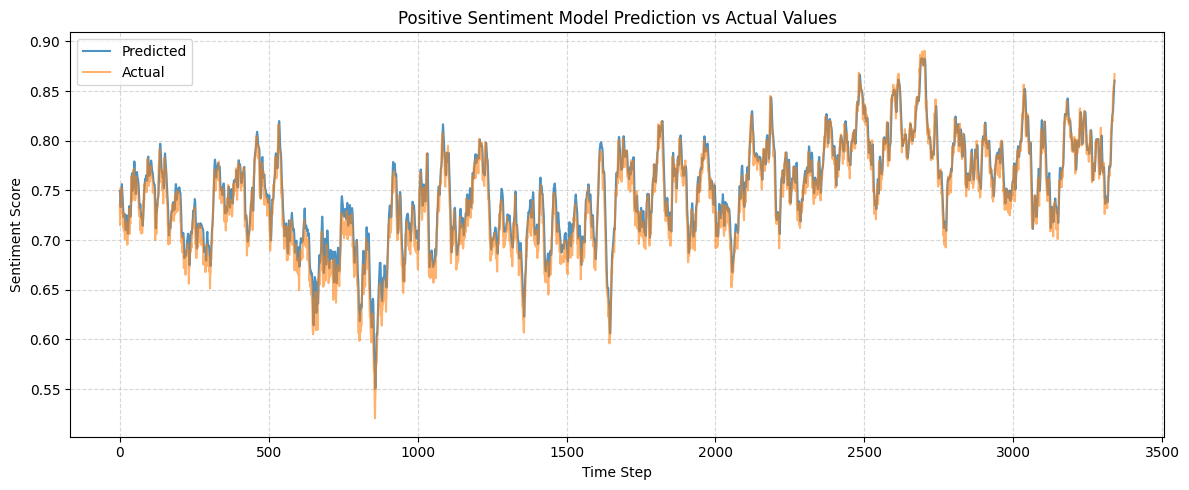

In [ ]:
plt.figure(figsize=(12, 5))

plt.plot(positive_score, label='Predicted',alpha=0.8)
plt.plot(positive_sentiment_model['Actual'], label='Actual',alpha=0.6)
plt.title('Positive Sentiment Model Prediction vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
mse = mean_squared_error(positive_score,positive_sentiment_model['Actual'])
rmse = np.sqrt(mse)
r2 = r2_score(positive_score,positive_sentiment_model['Actual'])
mae = mean_absolute_error(positive_score,positive_sentiment_model['Actual'])

print('mse : ',mse)
print('rmse : ',rmse)
print('r2 : ',r2)
print('mae : ',mae)

mse :  0.00021844603216414343
rmse :  0.014779919897081426
r2 :  0.9049450062321094
mae :  0.01187633990046151
